In [195]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.robust.norms import HuberT
from skbio.stats.composition import ilr,clr,alr
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
import seaborn as sns
from scipy.stats import skew

In [196]:
df = pd.DataFrame(pd.read_csv("./acs2015_census.csv"))
df = df.dropna()
print(df)

       CensusTract        State   County  TotalPop   Men  Women  Hispanic  \
0       1001020100      Alabama  Autauga      1948   940   1008       0.9   
1       1001020200      Alabama  Autauga      2156  1059   1097       0.8   
2       1001020300      Alabama  Autauga      2968  1364   1604       0.0   
3       1001020400      Alabama  Autauga      4423  2172   2251      10.5   
4       1001020500      Alabama  Autauga     10763  4922   5841       0.7   
...            ...          ...      ...       ...   ...    ...       ...   
73996  72153750501  Puerto Rico    Yauco      6205  3291   2914      99.7   
73997  72153750502  Puerto Rico    Yauco      2122   921   1201      99.2   
73998  72153750503  Puerto Rico    Yauco      2277  1097   1180      99.5   
73999  72153750601  Puerto Rico    Yauco      5267  2663   2604      98.8   
74000  72153750602  Puerto Rico    Yauco      2741  1181   1560      99.3   

       White  Black  Native  ...  Walk  OtherTransp  WorkAtHome  MeanCommut

In [197]:
#df = df[['TotalPop','Native','Hispanic','Asian','Pacific']]
#df = df[['Professional','Service','Office','Construction','Production']]
#df = df[['Drive','Carpool','Transit','Walk','OtherTransp']]
#df = df[['PrivateWork','PublicWork','SelfEmployed','FamilyWork']]

In [198]:
# Xác định các biến thành phần độc lập và biến giải thích
compositional_cols = ['PrivateWork','PublicWork','SelfEmployed','FamilyWork', 'Unemployment']

#data = 
var_target = df['TotalPop']
#family = family[(family != 0).all(axis=1)]

# chuyển dữ liệu thành phần
compositional_data = df[compositional_cols]
#compositional_data = compositional_data.div(compositional_data.sum(axis=1), axis=0)
compositional_data.head()


,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,77.1,18.3,4.6,0.0,5.4
1,77.0,16.9,6.1,0.0,13.3
2,64.1,23.6,12.3,0.0,6.2
3,75.7,21.2,3.1,0.0,10.8
4,67.1,27.6,5.3,0.0,4.2


In [199]:
# Thay thế các giá trị bằng 0 bằng một epsilon nhỏ
epsilon = 1e-9
compositional_data = compositional_data.replace(0, epsilon)

# Chuyển đổi dữ liệu thành phần bằng centered log-ratio (CLR)
clr_compositional_data = ilr(compositional_data)

# Chuyển dữ liệu CLR về dạng DataFrame để tiện sử dụng
#clr_compositional_data = pd.DataFrame(clr_compositional_data, columns=compositional_cols)
clr_compositional_data = pd.DataFrame(clr_compositional_data)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(clr_compositional_data, var_target, test_size=0.2, random_state=42)


# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Thêm cột hằng số vào X_train và X_test cho mô hình hồi quy
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# Tạo mô hình hồi quy mạnh mẽ (RLM) với chuẩn Huber
rlm_model = sm.RLM(y_train, X_train_scaled, M=HuberT())
rlm_results = rlm_model.fit()

# In kết quả mô hình
print(rlm_results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:               TotalPop   No. Observations:                58181
Model:                            RLM   Df Residuals:                    58176
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 23 Jun 2024                                         
Time:                        14:57:29                                         
No. Iterations:                    10                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4218.2124      7.744    544.711      0.0

In [200]:
# Dự đoán trên tập kiểm tra
y_pred = rlm_results.predict(X_test_scaled)

# Tính toán lỗi và RMSE
error = y_pred - y_test
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")


RMSE: 2025.3019454229718


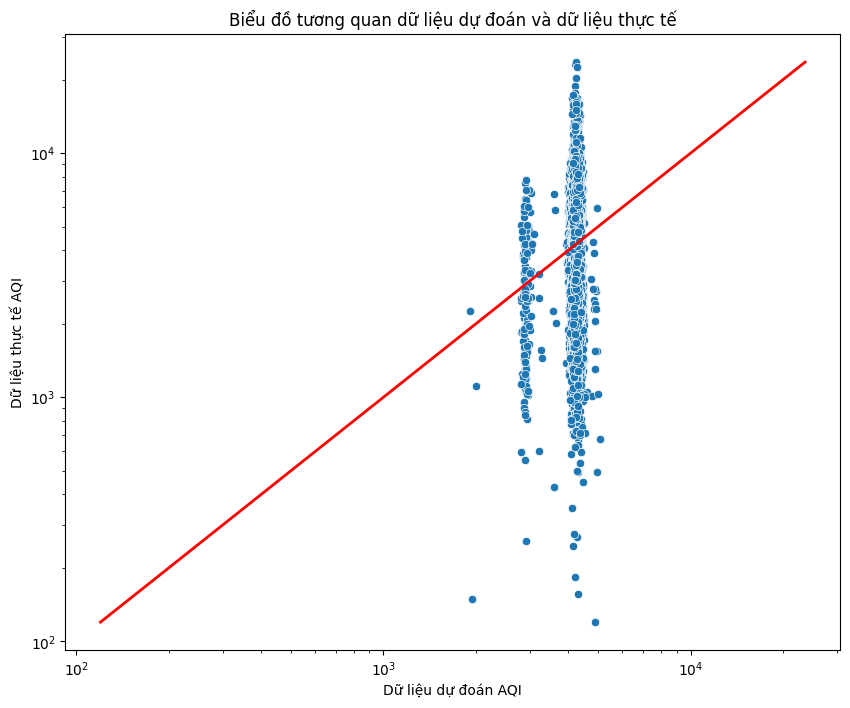

In [201]:
# Vẽ biểu đồ dự đoán so với giá trị thực tế
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_pred, y=y_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Dữ liệu dự đoán AQI')
plt.ylabel('Dữ liệu thực tế AQI')
plt.title('Biểu đồ tương quan dữ liệu dự đoán và dữ liệu thực tế')
plt.show()